In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
# Chargement des jeux train et test depuis S3
s3_train_uri = "s3://ociae-p11/results_train/"
s3_test_uri = "s3://ociae-p11/results/"
storage_options = {
    "key": os.environ["AWS_ACCESS_KEY_ID"],
    "secret": os.environ["AWS_SECRET_ACCESS_KEY"],
    "client_kwargs": {"region_name": os.environ.get("AWS_DEFAULT_REGION", "eu-west-1")}
}

In [3]:
df_train = pd.read_parquet(s3_train_uri, storage_options=storage_options)
df_test = pd.read_parquet(s3_test_uri, storage_options=storage_options)

In [4]:
print(f"🔹 Nombre de classes dans le train : {df_train['label'].nunique()}")
print(f"🔸 Nombre de classes dans le test : {df_test['label'].nunique()}")


🔹 Nombre de classes dans le train : 201
🔸 Nombre de classes dans le test : 201


/tmp/ipykernel_413/3565199099.py:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


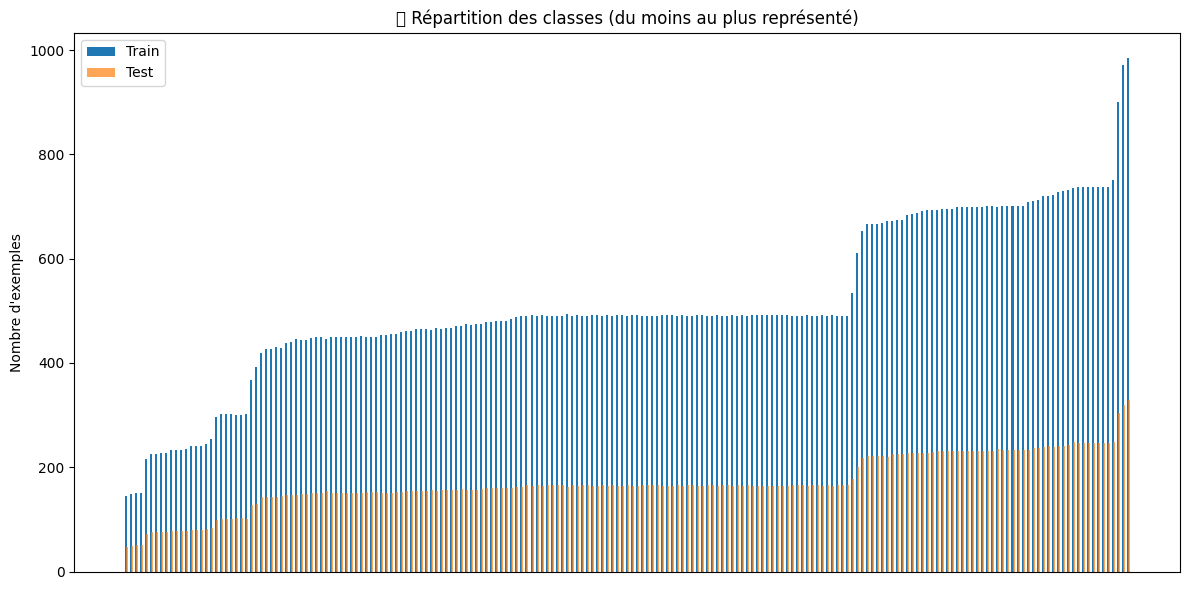

In [5]:
import matplotlib.pyplot as plt

# Comptage des classes
train_counts = df_train['label'].value_counts()
test_counts = df_test['label'].value_counts()

# Fusion des index pour avoir tous les labels
all_labels = sorted(set(train_counts.index).union(set(test_counts.index)))

# Construction d'un DataFrame combiné pour faciliter le tri
import pandas as pd

df_counts = pd.DataFrame({
    'label': all_labels,
    'train': [train_counts.get(label, 0) for label in all_labels],
    'test': [test_counts.get(label, 0) for label in all_labels],
})
df_counts['total'] = df_counts['train'] + df_counts['test']
df_counts = df_counts.sort_values(by='total')  # tri par effectif total croissant

# Affichage des barres
x = range(len(df_counts))
plt.figure(figsize=(12, 6))
plt.bar(x, df_counts['train'], width=0.4, label='Train', align='center')
plt.bar(x, df_counts['test'], width=0.4, label='Test', align='edge', alpha=0.7)
plt.xticks([])  # pas de labels sur l’axe x
plt.ylabel("Nombre d'exemples")
plt.title("📊 Répartition des classes (du moins au plus représenté)")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Extraction des vecteurs PCA
X_train = np.stack(df_train['pca_features'].apply(lambda d: d['values']))
X_test = np.stack(df_test['pca_features'].apply(lambda d: d['values']))
y_train = df_train['label'].values
y_test = df_test['label'].values

In [7]:
# Encodage des labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [8]:
# # Entraînement modèle 1: lr
# model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
# model.fit(X_train, y_train_encoded)

In [9]:
# Entraînement modèle 2: randomforest
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(
#     n_estimators=100,  # nombre d'arbres
#     max_depth=None,    # profondeur libre
#     random_state=42,
#     n_jobs=-1          # parallélisation
# )
# model.fit(X_train, y_train_encoded)

In [10]:
# Entrainement modèle 3 GradientBoosting
# from sklearn.ensemble import HistGradientBoostingClassifier

# Modèle avec quelques hyperparamètres ajustés
# model = HistGradientBoostingClassifier(
#     learning_rate=0.1,
#     max_iter=150,
#     max_leaf_nodes=64,
#     l2_regularization=1.0,
#     early_stopping=True,
#     random_state=42
# )

# start = time.time()
# model.fit(X_train, y_train_encoded)
# print(f"Temps d'entraînement : {time.time() - start:.2f} sec")

In [12]:
# pip install xgboost
# Entrainement modèle 4 XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import time

# Modèle XGBoost multiclass
model = XGBClassifier(
    objective='multi:softprob',
    num_class=201,
    learning_rate=0.1,
    n_estimators=150,
    max_depth=7,
    tree_method='hist',  # 'gpu_hist' si GPU dispo
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=1
)

start = time.time()
model.fit(X_train, y_train_encoded)
print(f"Temps d'entraînement : {time.time() - start:.2f} sec")

/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:32:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Temps d'entraînement : 2594.00 sec


In [13]:
# Prédictions
y_pred_encoded = model.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)
y_test_labels = le.inverse_transform(y_test_encoded)

In [14]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import adjusted_rand_score, classification_report

# Liste complète des labels
all_labels = sorted(df_train['label'].unique())

# ARI
ari = adjusted_rand_score(y_test_labels, y_pred)
print(f"Adjusted Rand Index (ARI) : {ari:.4f}")

# Jensen-Shannon Distance
real_dist = np.array([np.sum(y_test_labels == label) for label in all_labels])
pred_dist = np.array([np.sum(y_pred == label) for label in all_labels])
real_dist = real_dist / real_dist.sum()
pred_dist = pred_dist / pred_dist.sum()
js_distance = jensenshannon(real_dist, pred_dist)
print(f"Jensen-Shannon Distance (all labels) : {js_distance:.4f}")

# Rapport complet
report_dict = classification_report(
    y_test_labels, y_pred,
    labels=all_labels,
    zero_division=0,
    output_dict=True
)

# Conversion en DataFrame
report_df = pd.DataFrame(report_dict).T

# 🔸 1. Affichage des scores globaux
print("\n📈 Métriques globales :")
global_metrics = report_df.loc[['accuracy', 'macro avg', 'weighted avg']]
print(global_metrics[['precision', 'recall', 'f1-score', 'support']].to_string(float_format="%.4f"))

# 🔹 2. Affichage des scores par classe, triés
per_class_df = report_df.loc[report_df.index.isin(all_labels)]
per_class_df_sorted = per_class_df.sort_values(by='recall', ascending=False)

print("\n📊 Classification par classe (trié par rappel décroissant) :")
print(per_class_df_sorted[['precision', 'recall', 'f1-score', 'support']].to_string(float_format="%.4f"))




Adjusted Rand Index (ARI) : 0.8894
Jensen-Shannon Distance (all labels) : 0.0452

📈 Métriques globales :
              precision  recall  f1-score    support
accuracy         0.9398  0.9398    0.9398     0.9398
macro avg        0.9474  0.9421    0.9413 34314.0000
weighted avg     0.9437  0.9398    0.9381 34314.0000

📊 Classification par classe (trié par rappel décroissant) :
                           precision  recall  f1-score  support
Apple 10                      0.9315  1.0000    0.9645 231.0000
Cantaloupe 1                  1.0000  1.0000    1.0000 164.0000
Apple 11                      0.9595  1.0000    0.9793 142.0000
Grape Blue 1                  0.9909  1.0000    0.9954 328.0000
Granadilla 1                  0.9765  1.0000    0.9881 166.0000
Gooseberry 1                  0.9935  1.0000    0.9968 154.0000
Eggplant long 1               1.0000  1.0000    1.0000  80.0000
Cucumber 9                    0.9935  1.0000    0.9968 154.0000
Cucumber 5                    0.9957  1.0000  

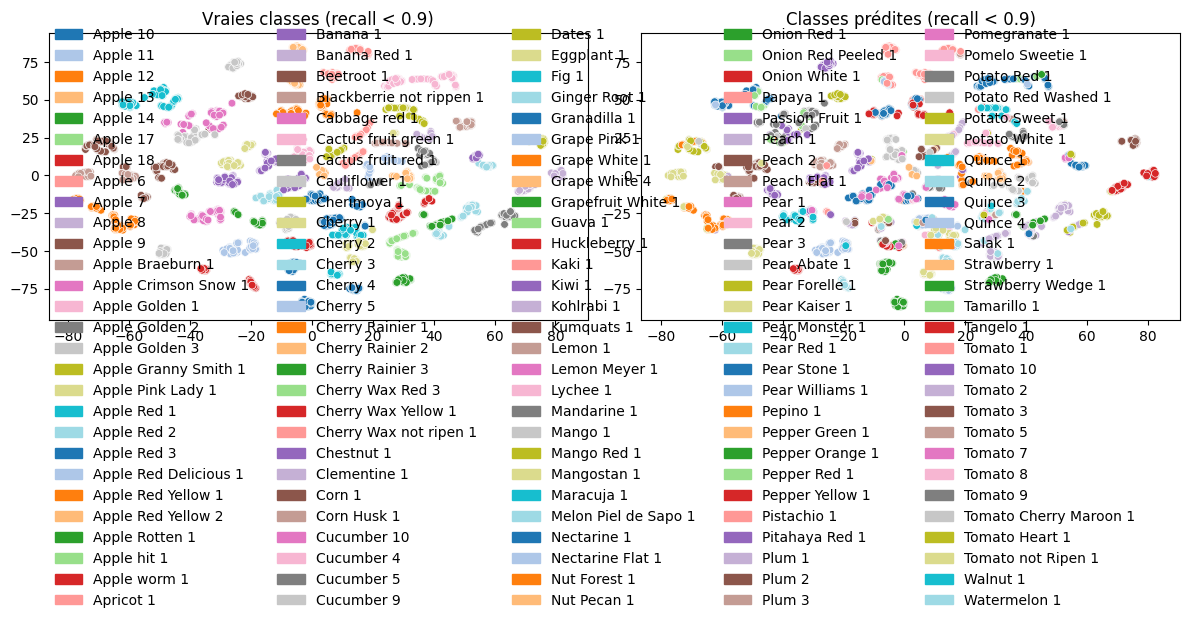

In [15]:
# Labels avec recall < 0.9
low_recall_labels = report_df[report_df['recall'] < 0.9].index.tolist()

# Création d’un masque booléen
mask = np.isin(y_test_labels, low_recall_labels)

# Données filtrées
X_tsne = X_test[mask]
y_true_tsne = y_test_labels[mask]
y_pred_tsne = y_pred[mask]

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Réduction t-SNE sur les classes à faible rappel
reducer = TSNE(n_components=2, random_state=42, perplexity=50)
X_2d = reducer.fit_transform(X_tsne)

# Plot
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_true_tsne, palette='tab20', s=30, legend=False, ax=ax1)
plt.title("Vraies classes (recall < 0.9)")
xlim, ylim = plt.xlim(), plt.ylim()
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_pred_tsne, palette='tab20', s=30, legend=False, ax=ax2)
plt.title("Classes prédites (recall < 0.9)")
plt.xlim(xlim)
plt.ylim(ylim)

# Légende uniquement pour les classes retenues
classes = sorted(set(y_true_tsne) | set(y_pred_tsne))
palette = sns.color_palette('tab20', len(classes))
handles = [mpatches.Patch(color=palette[i], label=cls) for i, cls in enumerate(classes)]
plt.figlegend(handles=handles, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.25), frameon=False)
plt.tight_layout()
plt.subplots_adjust(bottom=0.35)
plt.show()


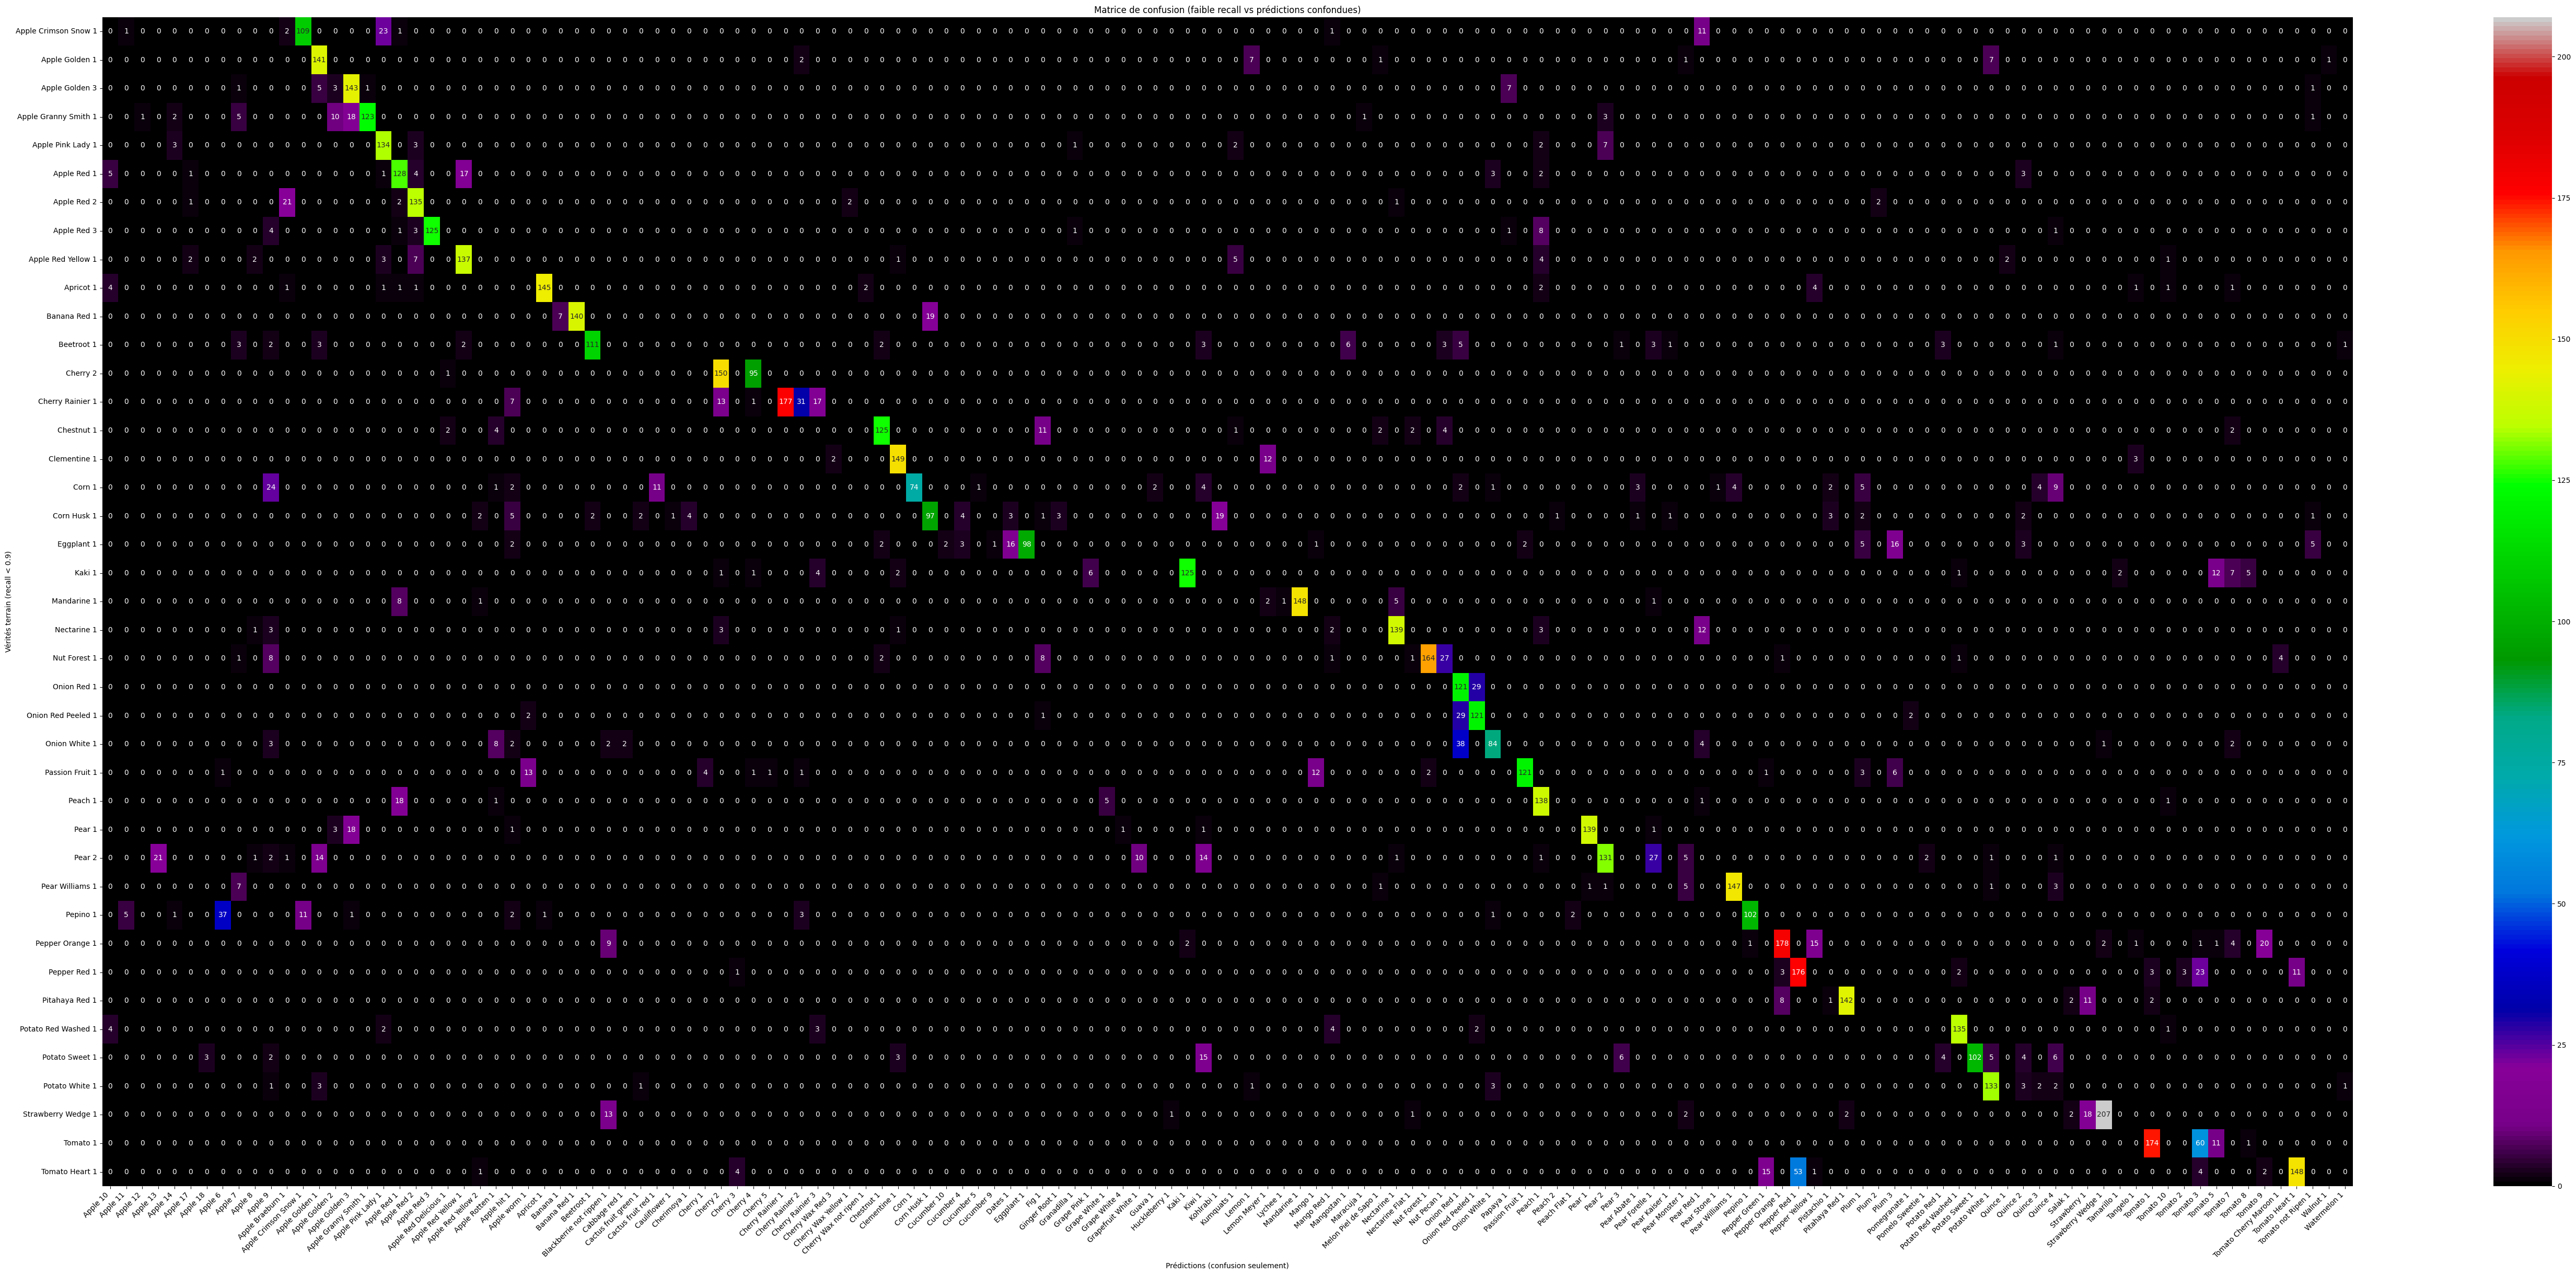

In [16]:
from sklearn.metrics import confusion_matrix

# Étape 1 : Calcul de la matrice complète
classes = sorted(list(set(y_test_labels) | set(y_pred)))
cm = confusion_matrix(y_test_labels, y_pred, labels=classes)

# Étape 2 : Filtrage des lignes (faible recall)
row_indices = [classes.index(lbl) for lbl in low_recall_labels]
cm_focus = cm[row_indices, :]  # lignes = low recall

# Étape 3 : Détection des colonnes utiles (au moins une confusion)
col_indices = np.where(cm_focus.sum(axis=0) > 0)[0]
confused_labels = [classes[i] for i in col_indices]
cm_trimmed = cm_focus[:, col_indices]

# Étape 4 : Affichage plus lisible
plt.figure(figsize=(max(12, len(confused_labels) * 0.4), len(low_recall_labels) * 0.5 + 4))
sns.heatmap(
    cm_trimmed,
    annot=True,
    fmt='d',
    cmap='nipy_spectral',
    xticklabels=confused_labels,
    yticklabels=low_recall_labels
)
plt.xlabel("Prédictions (confusion seulement)")
plt.ylabel("Vérités terrain (recall < 0.9)")
plt.title("Matrice de confusion (faible recall vs prédictions confondues)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
